# Final project report: Country of origin detection

## Introduction to task and dataset
In this project, the dataset is cross market mobile application dataset, it is collected to test the privacy of 100 most popular IOS and applications in three countries: India, China, and US. The goal is to use machine learning models to determine the country of origin for each applications using the network traffic trace. It is a three classes classification problem. For each sample, we have ipv4, TCP, UDP headers and payload data available. After download the traffic.pcapng file from nprint benchmark, I use commands like: nprint -P traffic.pcapng -W out20.npt -4 -t -u -p 20 to create several dataset with different size of payload used.

## nPrint data representation
The nPrint data representation is a special representation for network traffic. Instead of using domain knowledge to construct features manually from the packets, nprint allows we to directly use bits. The nprint fixed 480 features for ipv4 header information and another 480 features for TCP header information. In addition, UDP and ICMP headers both are transfered to 64 feautures. Finally, user can define the number of features need for the payload. Since each feature is a bit, so if the feature exist there are only two values available:zero and one. If the feature doesn't exist, -1 is used. For example, for TCP\IP packet, all UDP features are -1 since they don't exist.

## import libraries
Here are the libraries I used in this project.

In [1]:
from pcapng import FileScanner
from pcapng.blocks import EnhancedPacket
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import balanced_accuracy_score, classification_report, confusion_matrix, make_scorer
from xgboost import XGBClassifier, plot_importance
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

## Extract labels
The labels are encoded in the comment inside traffic.pcapng file, so I extract them for later supervised learning.

In [2]:
labels = []
with open("traffic.pcapng", "rb") as f:
    scanner = FileScanner(f)
    for block in scanner:
        if isinstance(block, EnhancedPacket):
            comment = block.options.get("opt_comment")
            if comment:
                country = comment.split(',')[1]
                labels.append(country)

## Fitting random forest model with different bytes of payloads
Using nprint, I create seven datasets with different bytes of payload data used, from 20 bytes to 80 bytes. Although more bytes of payload data means more information, the limited sample size of about 10000 in the dataset suggest not to use all the payload data. When we use a lot of features and the amount of data is limited, flexible models may just perfectly remember the data and lead to severe overfitting.

From my plot below, we can see that the accuracy first improves when increasing size from 20 bytes to 40 bytes. However, after 40 bytes, the accuracy drops because the number of features is relatively large compared to the training size and model start to overfit. I believe if we have more data, use more payload bytes will improve the model performance. However, in this dataset with about 10000 samples, using 40 bytes of payload is better. 

fitting random forest using 20 bytes of payload
fitting random forest using 30 bytes of payload
fitting random forest using 40 bytes of payload
fitting random forest using 50 bytes of payload
fitting random forest using 60 bytes of payload
fitting random forest using 70 bytes of payload
fitting random forest using 80 bytes of payload
fitting random forest using 100 bytes of payload
fitting random forest using 150 bytes of payload
fitting random forest using 200 bytes of payload


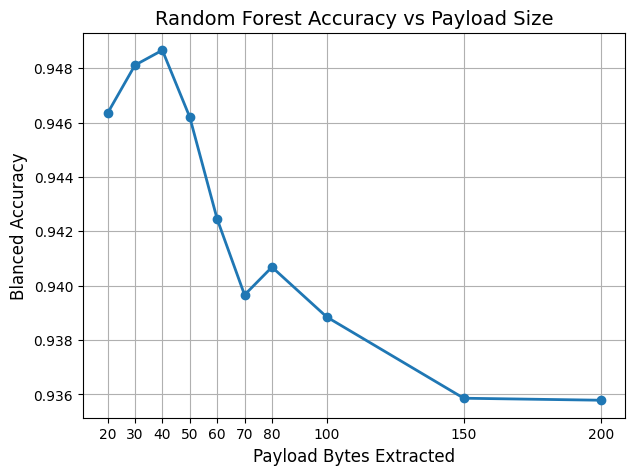

In [ ]:
# find how many bytes of payload should we use
# it takes 40s to run in my computer
payload_bytes = [20, 30, 40, 50, 60, 70, 80, 100, 150, 200]
accs = []
best_rf = None
for byte in payload_bytes:
    # create train text dataset based on data
    df = pd.read_csv(f'out{byte}.npt')
    X = df.drop(columns = 'src_ip')
    y = np.array(labels)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=100, stratify=y
    )
    clf = RandomForestClassifier(
    n_estimators=500,      
    random_state=100, 
    n_jobs= 8,
    )
    print(f'fitting random forest using {byte} bytes of payload')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = balanced_accuracy_score(y_test, y_pred)
    accs.append(acc)
    if acc >= max(accs):
        best_rf = clf

plt.figure(figsize=(7,5))
plt.plot(payload_bytes, accs, marker='o', linewidth=2)

plt.title("Random Forest Accuracy vs Payload Size", fontsize=14)
plt.xlabel("Payload Bytes Extracted", fontsize=12)
plt.ylabel("Blanced Accuracy", fontsize=12)

plt.grid(True)
plt.xticks(payload_bytes)
plt.show()


## Cross validation to select hyperparameters
Random forest is an ensemble of simple decision trees. Each simple decision tree is sensitive to data and become untable, so selecting different features and data by bootstrapping for each decision tree will make these decision trees almost independent to each other. Therefore, random forest take the majority vote from many decision trees as the result to overcome this problem of decision trees. Given the independence of the decision trees, the variance of their sum can be reduced effectively so random forest provide a more robust result. 

In this cross validation, I mainly tune two hyperparameters: the number of trees in random forest and the max depth of each tree. Although more trees will reduce variance and lead to better result, diminishing marginal return will happen. Fitting too many trees will be inefficient if smaller amount of trees can achieve similar result. The depth of tree is also an important feature, if we allow the tree to grow infinitely, the risk of overfitting increases. However, deeper tree indeed provide finer classification and can potentially achieve better result.

The final result for random forest model is to use 500 trees and not to set a maxium depth. The balanced accuracy on the test set is 0.949, smaller than the result in the paper, suggesting me to use more complex model.


In [4]:
# This cross validation take about 2.5 minutes. 

from sklearn.model_selection import GridSearchCV
df = pd.read_csv('out40.npt')
X = df.drop(columns = 'src_ip')
y = np.array(labels)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=100, stratify=y
)
param_grid = {
    "n_estimators":     [500, 700, 1000],
    "max_depth":        [10, 20, None],
}
balanced_accuracy_scorer = make_scorer(balanced_accuracy_score)
rf = RandomForestClassifier(random_state=100)
grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring=balanced_accuracy_scorer,
    n_jobs = 8,
    verbose=1
)
grid.fit(X_train, y_train)
print("\n Best Params:", grid.best_params_)
best_rf = grid.best_estimator_
y_pred = best_rf.predict(X_test)
acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced accuracy: {acc:.4f}")

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 9 candidates, totalling 45 fits

 Best Params: {'max_depth': None, 'n_estimators': 500}
Balanced accuracy: 0.9487
Classification Report:
              precision    recall  f1-score   support

       china       0.99      0.93      0.96       610
       india       0.93      0.98      0.95       815
          us       0.94      0.94      0.94       700

    accuracy                           0.95      2125
   macro avg       0.95      0.95      0.95      2125
weighted avg       0.95      0.95      0.95      2125

Confusion Matrix:
[[565  25  20]
 [  1 795  19]
 [  6  33 661]]


## Fit xgboost
xgboost is a kind of gradient boosting tree. The whole xgboost model contains many smaller trees, and each small tree is fitted sequentialy on the residuals of previous trees. With xgboost's special structure, they can use second order information like Hessian during optimization. Instead of pure gradient descent, xgboost use optimization similar to newton's method and lead to a stable optimization. Therefore, it is expected that xgboost can have a better result. In addition, since it is a tree based model, unlike deep learning models, we can see the feature importance and have a interpretable result.

For this xgboost model, I achieve balanced accuracy of 0.967 and it is very close to the result in the benchmark 0.968. Therefore, I decide not to use neural network model since the xgboost model can give interpretable result.

In [5]:
df = pd.read_csv('out40.npt')
X = df.drop(columns = 'src_ip')
y = np.array(labels)
encoder = LabelEncoder()
y = encoder.fit_transform(y) 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=100, stratify=y
)
xgb = XGBClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=8,
    eval_metric="mlogloss", 
    random_state = 100
)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {acc:.3f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Balanced Accuracy: 0.967
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       610
           1       0.95      0.98      0.96       815
           2       0.96      0.96      0.96       700

    accuracy                           0.97      2125
   macro avg       0.97      0.97      0.97      2125
weighted avg       0.97      0.97      0.97      2125


Confusion Matrix:
[[584  16  10]
 [  2 797  16]
 [  0  25 675]]


## feature importance of the xgboost model
Below shows the top 20 features for the xgboost model ordered by the gain. Gain is a meature of how this feature improve the model performance. From the table, we can see that most important features are tcp_ackf, tcp_opt, ipv4_ttl, ipv4 source and destination.

ipv4 TTL (Time-to-Live) decreases with each hop, so its value reveals geographical information. However, it will change if we change the measurement location. relying the distribution of TTL learned on that specific location will make the model not robust.
TCP ACK flags and TCP options may reflect country specific network architectures. 
The ipv4 source and destination also contains a lot of information, since they encode regional address blocks and routing allocations. Applications tend to communicate with country specific data centers the addresses observed in packet flows reveal geographic association. However, it is possible that a US designed application run on cloud in China for Chinese user, so using this feature may not be proper in this case.

This feature importance exploration reveal the fact that although nprint provide very convenient data representation for network traffic. Without understanding the features clearly, the model may fit on some features that can improve model performance but may be irrelevant to the problem we actually want to solve. As a result, they may be a big gap between the result we get in model evaluation step and the model performance in actual depolyment.

In [6]:
importance_dict = xgb.get_booster().get_score(importance_type='gain')
importance_df = pd.DataFrame.from_dict(importance_dict, orient='index', columns=['gain'])
importance_df = importance_df.sort_values(by='gain', ascending=False)
importance_df.head(20)

,gain
tcp_ackf_0,87.605499
tcp_opt_64,33.007622
ipv4_ttl_5,32.527515
ipv4_ttl_4,27.602900
tcp_opt_32,27.557949
tcp_opt_65,24.454216
tcp_opt_33,20.853487
tcp_opt_66,15.708938
ipv4_dst_30,14.763415
ipv4_src_23,12.353851
